In [26]:
import geopandas as gpd
import momepy
import networkx as nx
import graph_tool.all as gt
from scripts.nx2gt import nx2gt
import pandas as pd
import matplotlib
import itertools
from shapely.geometry import LineString, point
from shapely.wkt import loads
from tqdm import tqdm
import numpy as np
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask
import math
import concurrent.futures
import matplotlib.pyplot as plt
import osmnx as ox

In [27]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [28]:
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).reset_index(drop=True)

In [29]:
streets

,geometry
0,"LINESTRING (254595.109 664390.697, 254660.836 ..."
1,"LINESTRING (254595.109 664390.697, 254660.232 ..."
2,"LINESTRING (253684.000 664697.747, 253722.925 ..."
3,"LINESTRING (254849.562 664336.774, 254873.037 ..."
4,"LINESTRING (254849.562 664336.774, 254876.557 ..."
...,...
15130,"LINESTRING (254149.471 664975.440, 254101.575 ..."
15131,"LINESTRING (259902.956 669716.906, 259901.131 ..."
15132,"LINESTRING (259995.425 669715.044, 260008.139 ..."
15133,"LINESTRING (259995.425 669715.044, 259902.956 ..."


In [30]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42779 instead
  warnings.warn(
2023-12-20 03:14:10,051 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-20 03:14:10,054 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-20 03:14:10,059 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-20 03:14:10,061 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-20 03:14:10,065 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-20 03:14:10,068 - distributed.nanny.memory - WAR

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42779/status,
Dashboard: http://127.0.0.1:42779/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43951,Workers: 8
Dashboard: http://127.0.0.1:42779/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:36141,Total threads: 2
Dashboard: http://127.0.0.1:36505/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:45201,


In [31]:
# Create a pandas dataframe from the multigraph
primal = momepy.gdf_to_nx(streets, length = "mm_len", approach='primal')

In [32]:
vertID_dict = {}

In [33]:
counter = itertools.count()

for node in primal.nodes():
    id = next(counter)
    primal.nodes[node]['vertID'] = id
    vertID_dict[id] = node

In [34]:
inverted_vertID_dict = {value: key for key, value in vertID_dict.items()}

# Street Network Shapes

In [35]:
edg_lin = momepy.Linearity(streets)
streets['linearity'] = edg_lin.series

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/geopandas/geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


## Node Degree

In [36]:
# Convert it to a graph-tool graph
gtG = nx2gt(primal)

gtG.list_properties()

g = gt.GraphView(gtG)
mm_len = gtG.edge_properties["mm_len"]
vp, ep = gt.betweenness(g, weight = mm_len)

node_degree = {g.vertex_index[v]: v.in_degree() + v.out_degree() for v in g.vertices()}
# convert ID_dict to a DataFrame and rename the index and column
node_degree = pd.DataFrame.from_dict(node_degree, orient='index').rename(columns={0: "node_degree"})
# merge vertID_df and vertices on vertID and node, respectively

approach       (graph)   (type: string, val: primal)
id             (vertex)  (type: string)
vertID         (vertex)  (type: double)
geometry       (edge)    (type: string)
mm_len         (edge)    (type: double)


/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


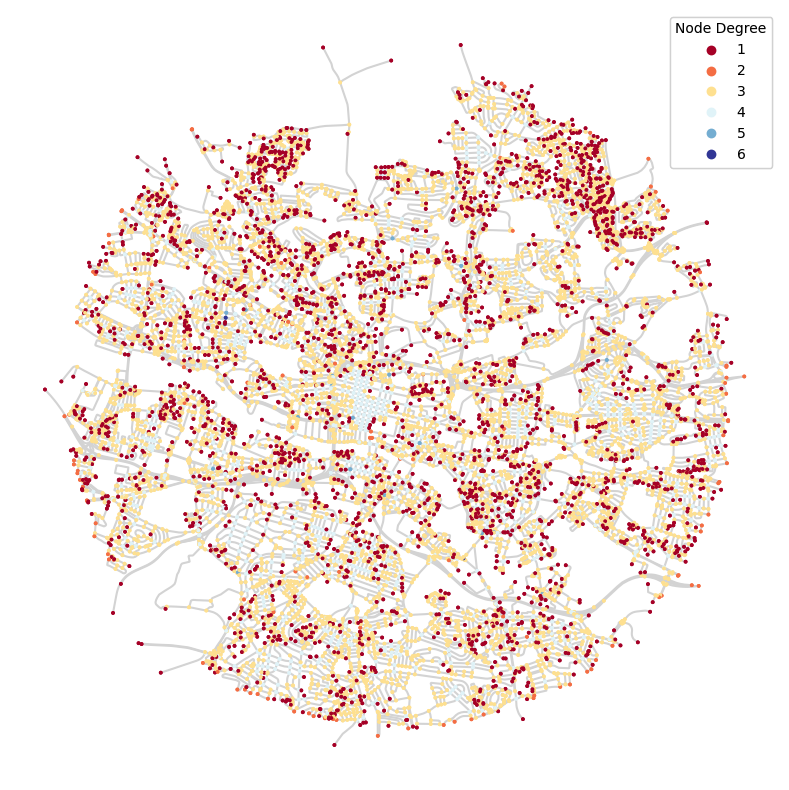

In [37]:
# cross-testing to Momepy implementation

degree = dict(nx.degree(primal))
nx.set_node_attributes(primal, degree, 'degree')

graph = momepy.node_degree(primal, name='degree')

nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
                                    spatial_weights=True)

f, ax = plt.subplots(figsize=(10, 10))

# Plot edges with a lower zorder
edges.plot(ax=ax, color='lightgrey', zorder=1)

# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='degree', cmap='RdYlBu', markersize=3, zorder=2)

# Plot nodes
scatter = ax.scatter(nodes.geometry.x, nodes.geometry.y, c=nodes['degree'], cmap='RdYlBu', s=3, zorder=2)

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="upper right", title="Node Degree")
ax.add_artist(legend1)

ax.set_axis_off()
plt.show()

node_degree["node_degree"]
node_degree_aligned = node_degree["node_degree"].reset_index(drop=True)
nodes_aligned = nodes["degree"].reset_index(drop=True)

# Check if all elements are equal
if not (node_degree_aligned == nodes_aligned).all():
    raise ValueError("All elements in node_degree_aligned and nodes_aligned are identical.")

# Meshedness + clustering

Eucledean Dist

In [38]:
primal_scattered = client.scatter(primal)

@delayed
def compute_ego_graph_eucl(n, primal_scattered, radius):
    graph = nx2gt(nx.ego_graph(primal_scattered, n, radius, distance="mm_len"))
    return (n, graph)

tasks = []
for n in primal.nodes():
    task = compute_ego_graph_eucl(n, primal_scattered, 500)
    tasks.append(task)
    
results = dask.compute(*tasks)

In [39]:
def calculate_meshedness(graph):
    e = graph.num_edges()
    v = graph.num_vertices()

    if v < 3:  # To avoid division by zero in the formula
        return 0

    meshedness_coefficient = (e - v + 1) / (2 * v - 5)
    return meshedness_coefficient

In [40]:
ego_graph_eucl_collection = {}

meshedness_eucl_500 = []

for n, ego_graph in results:
    
    meshedness_eucl_500.append(calculate_meshedness(ego_graph))
    
    if n in ego_graph_eucl_collection.keys():
        raise Exception("n in ego_graph_collection")
    
    ego_graph_eucl_collection[n] = {}
    
    ego_graph_eucl_collection[n]["graph"] = ego_graph

    if len(list(ego_graph.edges())) > 1:
        ego_graph_eucl_collection[n]["weight"] = ego_graph.edge_properties["mm_len"]
    else:
        ego_graph_eucl_collection[n]["weight"] = None
        
    ego_graph_eucl_collection[n]["node"] = ego_graph.get_vertices()[[i for i,v in enumerate(ego_graph.vp.vertID.get_array()) if v == inverted_vertID_dict[n]][0]]

In [41]:
meshedness_eucl_500 = pd.Series(meshedness_eucl_500)

100%|██████████| 11584/11584 [00:12<00:00, 944.89it/s] 


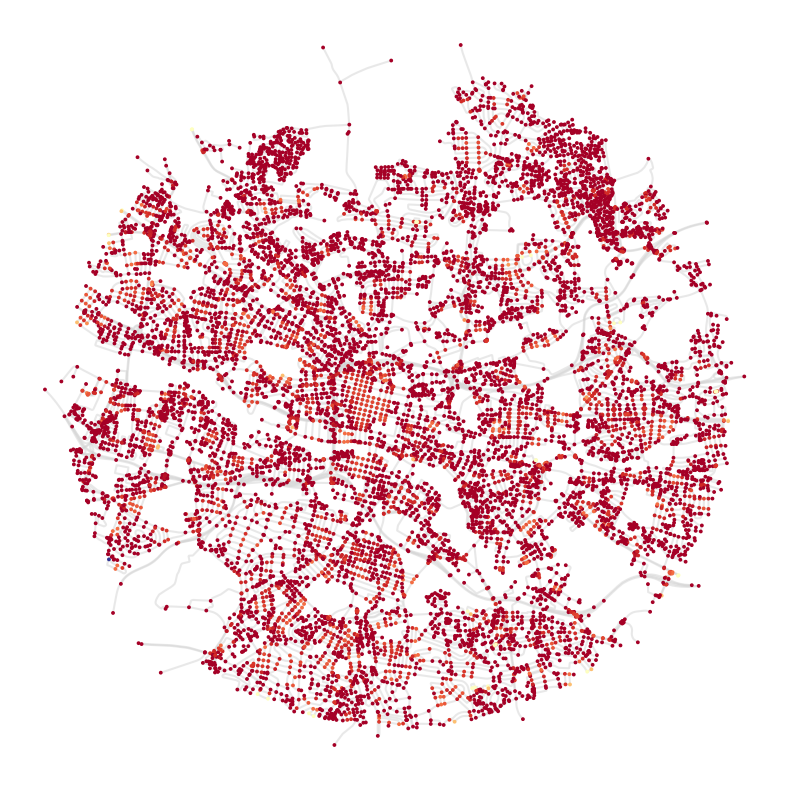

In [43]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=500, name='meshedness_eucl_500', distance='mm_len')

nodes = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='RdYlBu', markersize=3, zorder=2)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

meshedness_eucl_500 = meshedness_eucl_500.reset_index(drop=True)
nodes_aligned = nodes["meshedness_eucl_500"].reset_index(drop=True)

# Check if all elements are equal
if not (meshedness_eucl_500 == nodes_aligned).all():
    raise ValueError("All elements in node_degree_aligned and nodes_aligned are not identical.")

Topological Distance

In [44]:
primal_scattered = client.scatter(primal)

@delayed
def compute_ego_graph_topo(primal_scattered, n, radius):
    graph = nx2gt(nx.ego_graph(primal_scattered, n, radius, distance=None))
    return (n, graph)

tasks = []
for n in primal.nodes():
    task = compute_ego_graph_topo(primal_scattered, n, 5)
    tasks.append(task)
    
results = dask.compute(*tasks)


In [45]:
def calculate_meshedness(graph):
    e = graph.num_edges()
    v = graph.num_vertices()

    if v < 3:  # To avoid division by zero in the formula
        return 0

    meshedness_coefficient = (e - v + 1) / (2 * v - 5)
    return meshedness_coefficient

In [46]:
ego_graph_top_collection = {}

In [47]:
ego_graph_top_collection = {}

meshedness_top_5 = []

for n, ego_graph in results:
    
    meshedness_top_5.append(calculate_meshedness(ego_graph))
    
    if n in ego_graph_top_collection.keys():
        raise Exception("n in ego_graph_collection")
    
    ego_graph_top_collection[n] = {}
    
    ego_graph_top_collection[n]["graph"] = ego_graph

    if len(list(ego_graph.edges())) > 1:
        ego_graph_top_collection[n]["weight"] = ego_graph.edge_properties["mm_len"]
    else:
        ego_graph_top_collection[n]["weight"] = None
        
    ego_graph_eucl_collection[n]["node"] = ego_graph.get_vertices()[[i for i,v in enumerate(ego_graph.vp.vertID.get_array()) if v == inverted_vertID_dict[n]][0]]

In [48]:
meshedness_top_5 = pd.Series(meshedness_top_5)

In [49]:
meshedness_top_5

0        0.110092
1        0.123596
2        0.121739
3        0.119658
4        0.120482
           ...   
11579    0.066667
11580    0.090909
11581    0.090909
11582    0.137931
11583    0.137931
Length: 11584, dtype: float64

100%|██████████| 11584/11584 [00:10<00:00, 1073.10it/s]


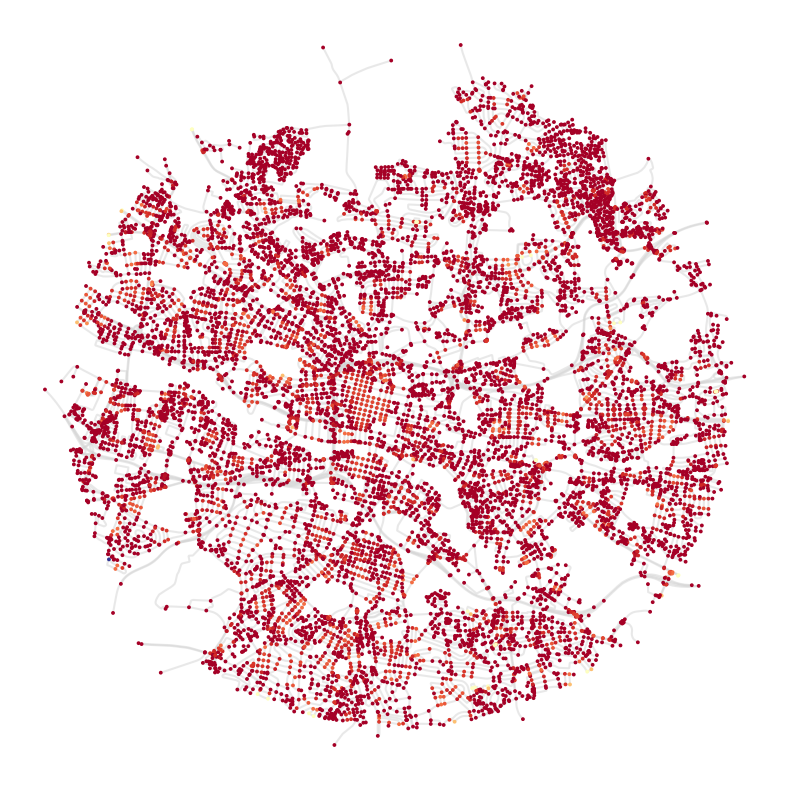

In [50]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=5, name='meshedness_top_5')

nodes = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='RdYlBu', markersize=3, zorder=2)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

meshedness_top_5 = meshedness_top_5.reset_index(drop=True)
nodes_aligned = nodes["meshedness_top_5"].reset_index(drop=True)

# Check if all elements are equal
if not (meshedness_top_5 == nodes_aligned).all():
    raise ValueError("All elements in node_degree_aligned and nodes_aligned are not identical.")

# Multiple Centrality Analysis

## Closeness Centrality

In [51]:
closeness = {k:gt.closeness(ego_graph_eucl_collection[k]["graph"], weight=ego_graph_eucl_collection[k]["weight"], source=ego_graph_eucl_collection[k]["node"]) for k in tqdm(ego_graph_eucl_collection)}
closeness_centrality_eucl = pd.DataFrame({'closeness_centrality_eucl': closeness})

  0%|          | 0/11584 [00:00<?, ?it/s]/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/graph_tool/centrality/__init__.py:468: RuntimeWarning: divide by zero encountered in divide
  c = 1. / dists.sum()
/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/graph_tool/centrality/__init__.py:470: RuntimeWarning: invalid value encountered in multiply
  c *= len(dists)
  0%|          | 3/11584 [00:00<00:07, 1505.13it/s]


ValueError: Invalid vertex index: 46

In [ ]:
# test with NetworkX implementation
graph = momepy.closeness_centrality(primal, radius=500, name='closeness_centrality_eucl_500', distance='mm_len', weight='mm_len')

nodes = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

closeness_centrality_eucl = closeness_centrality_eucl.reset_index(drop=True)
nodes_aligned = nodes["closeness_centrality_eucl_500"].reset_index(drop=True)

# Check if all elements are equal
if not (meshedness_top_5 == nodes_aligned).all():
    raise ValueError("All elements in node_degree_aligned and nodes_aligned are not identical.")

nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness_centrality_eucl_500', cmap='RdYlBu', markersize=3, zorder=2)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()
